<a href="https://colab.research.google.com/github/xcsengody/DP/blob/master/xcsengody_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.111.129.242:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.111.129.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9804429107072208445)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3486259635907843847)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 602106630216889913)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3578611041490123444)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/dev

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
root='/content/drive/My Drive/DP/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip -q install parfit

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pylab as pl
from pylab import rcParams
from google.colab import files
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import (SMOTE,SVMSMOTE,ADASYN)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import parfit.parfit as pf
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.model_selection import ParameterGrid
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import (train_test_split,RandomizedSearchCV, GridSearchCV)
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn import metrics
from pprint import pprint
from sklearn.metrics import (roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

In [0]:
def plot_roc_curve(fpr, tpr):  
  plt.plot(fpr, tpr, color='orange', label='ROC')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.show()

def predict(clf, X, y, title):
  print("\n")
  print(title)
  print("\n")
  prediction = clf.predict(X)

  accuracy = accuracy_score(y, prediction)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))

  print("\nClassification Report\n {}\n".format(classification_report(y, prediction)))

  print("\nConfusion-matrix\n {}\n".format(pd.crosstab(y, prediction, rownames=['Actual Species'], colnames=['Predicted Species'])))

  # ROC-AUC for binary class model performance evaluation
  proba = clf.predict_proba(X)
  proba = [p[1] for p in proba]
  print("\nROC-AUC: {}\n".format(roc_auc_score(y, proba)))
  
  fpr, tpr, thresholds = roc_curve(y.values, proba)
  plot_roc_curve(fpr, tpr)
  print("\n")

  #score = metrics.f1_score(y_test, prediction, average=None)
  #print("F1 score: {}".format(score))

  #cv = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
  #print("Standard Cross-validation accuracy: %f (+/- %f)" % (cv.mean(), (cv.std()*2)))

  #skfold = StratifiedKFold(n_splits=10)

  #skfold_cv = cross_val_score(clf, X_train, y_train, cv=skfold, scoring='roc_auc')
  #print("Stratified K-fold Cross-validation accuracy of train set: %f (+/- %f)\n" % (skfold_cv.mean(), (skfold_cv.std()*2)))

  #skfold_cv = cross_val_score(clf, X_valid, y_valid, cv=skfold, scoring='roc_auc')
  #print("Stratified K-fold Cross-validation accuracy of validation set: %f (+/- %f)\n" % (skfold_cv.mean(), (skfold_cv.std()*2)))

  # Confusion-matrix usually used to evaluate the performance of a multiclass model.
  #conf_mat = confusion_matrix(y_test, prediction)
  #sns.heatmap(conf_mat,annot=True)
  #plt.title("Confusion-matrix")
  #plt.figure(figsize=(20,20))
  #plt.show()

In [0]:
pd.set_option('display.max_rows', 500);
pd.set_option('display.max_columns', None);
rcParams['figure.figsize'] = 15, 8;
sns.set(style="whitegrid");

In [0]:
#dataset=dataset.reset_index();
#dataset=dataset.set_index('index');

#joblib.dump(clf, 'randomforestmodel.sav')
#clf = joblib.load(root+'/Model/randomforestmodel_bin.sav')

In [0]:
df1_pth = root+"Dataset/dataset_1.csv";
df2_pth = root+"Dataset/dataset_2.csv";
df3_pth = root+"Dataset/dataset_3.csv";
df4_pth = root+"Dataset/dataset_4.csv";

In [0]:
#Try index_col=0 to prevent deletion unnamed column
df1 = pd.read_csv(df1_pth, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);
df2 = pd.read_csv(df2_pth, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);
df3 = pd.read_csv(df3_pth, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);
df4 = pd.read_csv(df4_pth, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);

Tokenization took: 8287.23 ms
Type conversion took: 9131.67 ms
Parser memory cleanup took: 51.75 ms
Tokenization took: 7308.81 ms
Type conversion took: 9158.78 ms
Parser memory cleanup took: 37.52 ms
Tokenization took: 9080.98 ms
Type conversion took: 8916.01 ms
Parser memory cleanup took: 34.81 ms
Tokenization took: 5127.32 ms
Type conversion took: 5649.28 ms
Parser memory cleanup took: 15.68 ms


In [0]:
print("NaN columns {}".format(df2.columns[df2.isna().any()].tolist()))

NaN columns []


In [0]:
print("Dataset no. 1\n({}, {})\n".format(df1.shape[0],df1.shape[1]))
print("Dataset no. 2\n({}, {})\n".format(df2.shape[0],df2.shape[1]))
print("Dataset no. 3\n({}, {})\n".format(df3.shape[0],df3.shape[1]))
print("Dataset no. 4\n({}, {})\n".format(df4.shape[0],df4.shape[1]))

Dataset no. 1
(699984, 50)

Dataset no. 2
(699999, 50)

Dataset no. 3
(699999, 50)

Dataset no. 4
(440042, 50)



Total rows: 1140041
Total features: 50
Normal traffic: 893722 (78.39 %)
Attack traffic: 246319 (21.61 %)


Text(0, 0.5, 'Frequency')

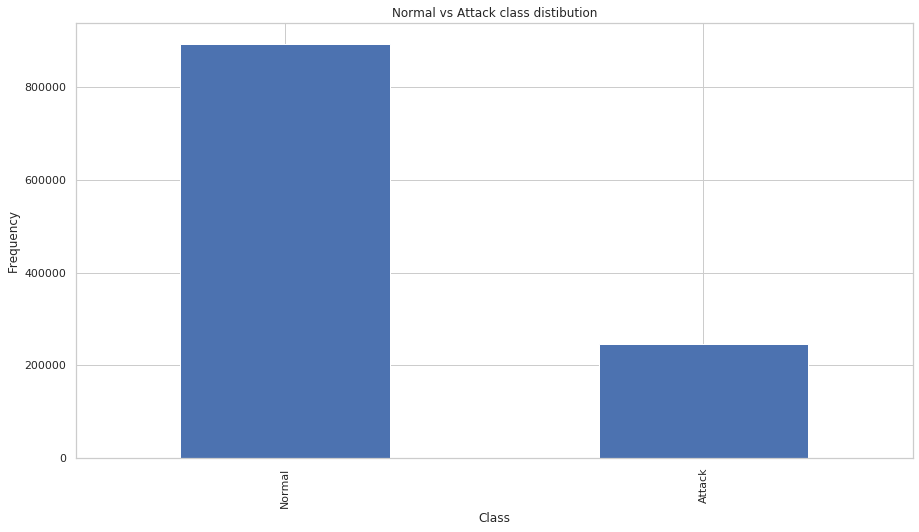

In [0]:
set1 = set(df3.columns)
set2 = set(df4.columns)

print("Missing columns: {}".format(list(sorted(set1 - set2)))
print("Missing columns: {}".format(list(sorted(set2 - set1)))

#frames = [df1, df2, df3, df4]
frames = [df3, df4]
dataset = pd.concat(frames)
dataset = dataset.sample(frac=1).reset_index(drop=True)
#dataset.to_csv('dataset.csv')

attack_traffic=dataset[dataset.label.apply(lambda x: x==1)]
normal_traffic=dataset[dataset.label.apply(lambda x: x==0)]
total_features=dataset.shape[1];
total_rows=dataset.shape[0];
normal_traffic_rows=normal_traffic.shape[0];
normal_traffic_per=(100*normal_traffic_rows)/total_rows;
attack_traffic_rows=attack_traffic.shape[0];
attack_traffic_per=(100*attack_traffic_rows)/total_rows;

print("Total rows: {}\nTotal features: {}\nNormal traffic: {} ({} %)\nAttack traffic: {} ({} %)".
      format(total_rows, total_features, normal_traffic_rows, float("{0:.2f}".format(normal_traffic_per)), attack_traffic_rows, float("{0:.2f}".format(attack_traffic_per))));

count_classes = pd.value_counts(dataset.label)
count_classes.plot(kind="bar")
plt.title("Normal vs Attack class distibution")
plt.xticks(range(2), ["Normal","Attack"])
plt.xlabel("Class")
plt.ylabel("Frequency")

In [0]:
y = dataset.label
X = dataset.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print("Train set size: {}\nTest set size: {}\nValidation set size: {}".format(X_train.shape[0],X_test.shape[0],X_valid.shape[0]))

class_weights_arr = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {};

i=0
for cw in class_weights_arr:
  class_weights[i] = cw;
  i+=1

Train set size: 729625
Test set size: 228009
Validation set size: 182407


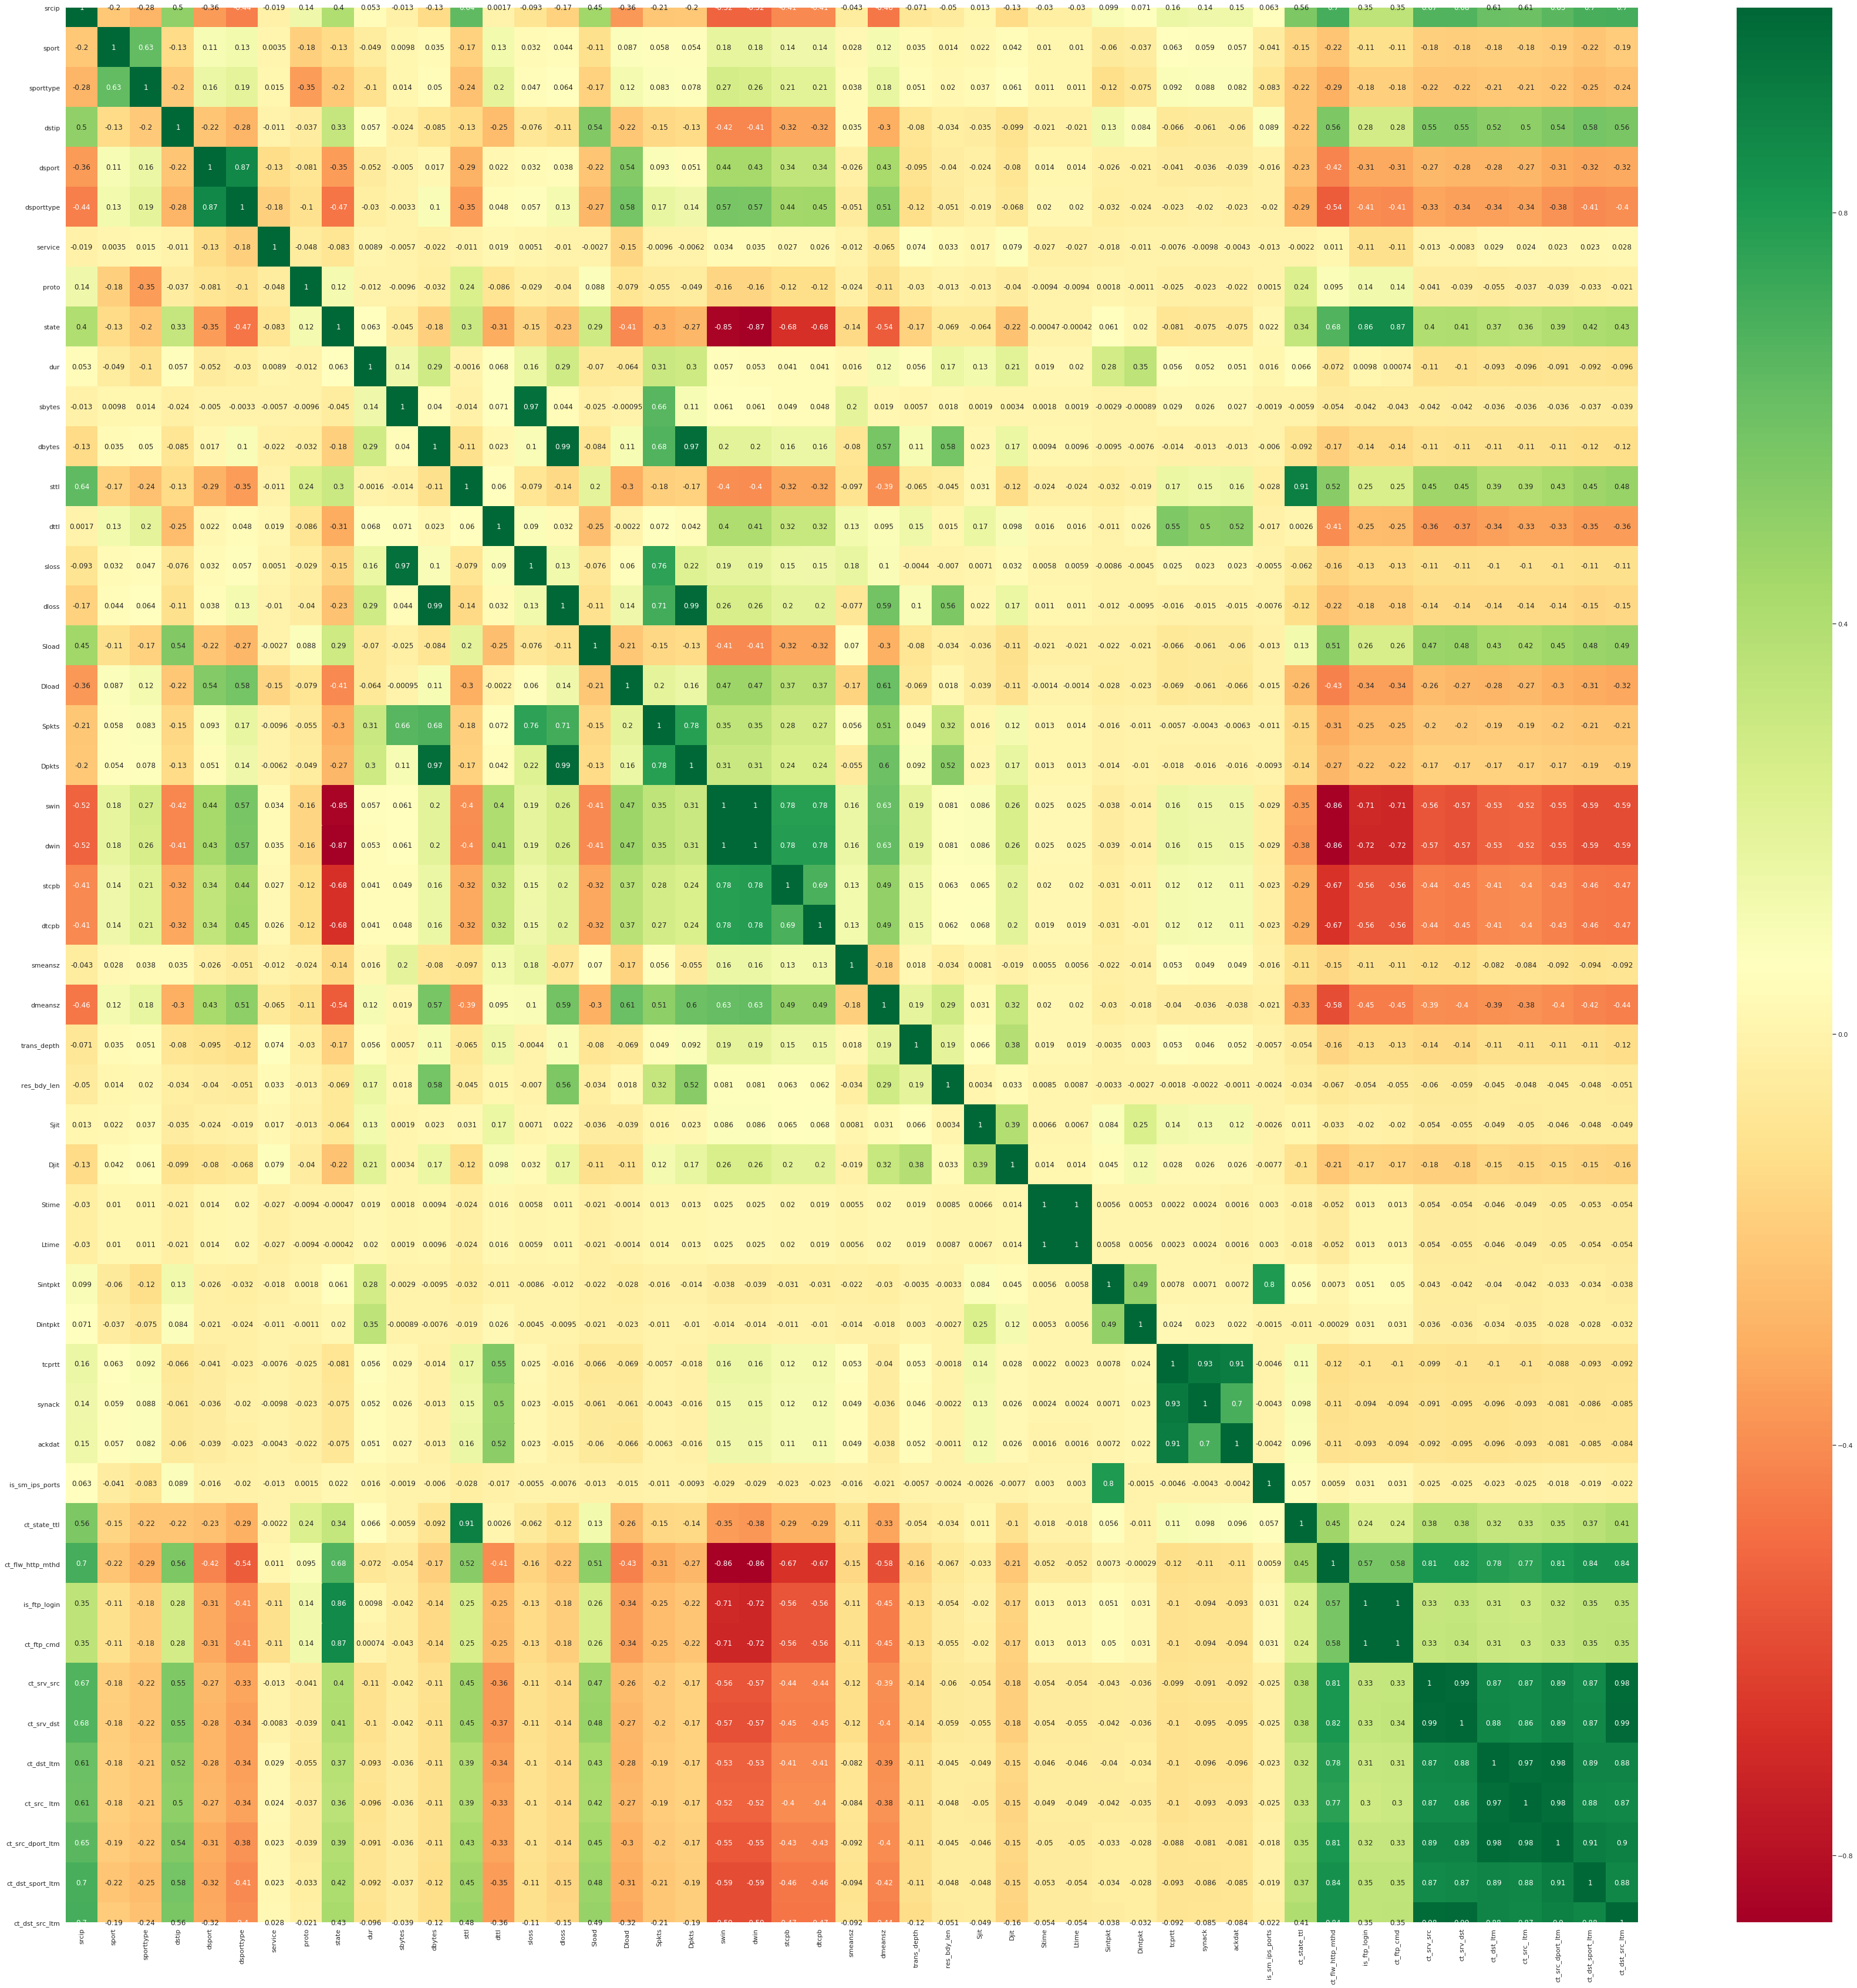

In [0]:
#Correlation matrix
corrmat = X_train.corr()
top_corr_features = corrmat.index
pl.figure(figsize=(60,60))
g=sns.heatmap(X_train[top_corr_features].corr(method='pearson', min_periods=1),annot=True,cmap="RdYlGn")

In [0]:
# ---> Logistic Regression <---

In [0]:
logisticRegression_model = LogisticRegression()
rfe = RFE(logisticRegression_model, n_features_to_select=None, step=8, verbose=2)
logisticRegression = rfe.fit(X_train, y_train)

selected_columns=[]
columns = X_train.columns
ranked_columns = rfe.support_

for i in range(len(ranked_columns)):
  if ranked_columns[i] == True:
    selected_columns.append(columns[i])

X_train_logreg=X_train[selected_columns]

logisticRegression_model=sm.Logit(y_train,X_train_logreg)
logisticRegression=logisticRegression_model.fit()
print(logisticRegression.summary2())

Fitting estimator with 49 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 41 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 33 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 25 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Optimization terminated successfully.
         Current function value: 0.041448
         Iterations 17
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.921      
Dependent Variable:   label            AIC:              60530.4567 
Date:                 2019-12-02 19:38 BIC:              60806.4636 
No. Observations:     729625           Log-Likelihood:   -30241.    
Df Model:             23               LL-Null:          -3.8065e+05
Df Residuals:         729601           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       17.0000                                       
--------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
srcip             -1.0634   0.0326 -32.5701 0.0000  -1.1274  -0.9994
dstip            -25.7508  

In [0]:
selected_columns=['srcip',
                  'dstip',
                  'dsport',
                  'proto',
                  'state',
                  'dbytes',
                  'sttl',
                  'dttl',
                  'sloss',
                  'dloss',
                  'Dload',
                  'Spkts',
                  'Dpkts',
                  'swin',
                  'dmeansz',
                  'tcprtt',
                  'synack',
                  'ackdat',
                  'ct_state_ttl',
                  'is_ftp_login',
                  'ct_srv_src',
                  'ct_srv_dst',
                  'ct_dst_sport_ltm',
                  'ct_dst_src_ltm']
                  
X_train_logreg=X_train[selected_columns]

logisticRegression_model=sm.Logit(y_train,X_train_logreg)
logisticRegression=logisticRegression_model.fit()
print(logisticRegression.summary2())

Optimization terminated successfully.
         Current function value: 0.031860
         Iterations 18
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.937      
Dependent Variable:   label            AIC:              17987.4274 
Date:                 2019-12-01 17:45 BIC:              18208.9424 
No. Observations:     281626           Log-Likelihood:   -8972.7    
Df Model:             20               LL-Null:          -1.4156e+05
Df Residuals:         281605           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       18.0000                                       
--------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
srcip             12.2140   0.3517  34.7267 0.0000  11.5246  12.9034
dstip            -46.2165  

In [0]:
params = {'penalty': ['l2'],
         'dual': [False],
         'C':[.009,0.01,.09,1,5],
         'solver': ['lbfgs','saga'],
         'max_iter': [100,500],
         'multi_class': ['ovr','auto'],
         'warm_start': [True,False]}

logisticRegression_model = LogisticRegression()
logisticRegression_gridSearch = GridSearchCV(logisticRegression_model, param_grid = params, cv = 10, n_jobs=-1, verbose=2)
logisticRegression_gridSearch = logisticRegression_gridSearch.fit(X_train, y_train)

pprint(logisticRegression_gridSearch.best_params_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 24.8min finished


{'C': 5,
 'dual': False,
 'max_iter': 500,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'warm_start': True}


In [0]:
'''
{'C': 5,
 'dual': False,
 'max_iter': 500,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'warm_start': True}
'''

logisticRegression_model = LogisticRegression(solver='lbfgs',penalty='l2',multi_class='ovr',C=5,max_iter=500,warm_start=True,dual=False,n_jobs=-1,verbose=2)
selectTopFeatures=False;

if selectTopFeatures:
  X_train_logreg=X_train[selected_columns]
  X_test_logreg=X_test[selected_columns]
  X_valid_logreg=X_valid[selected_columns]

  logisticRegression_selectedFeatures = logisticRegression_model.fit(X_train_logreg, y_train)
  joblib.dump(logisticRegression_selectedFeatures, 'logisticRegression_selectedFeatures.sav')
  predict(logisticRegression_selectedFeatures, X_test_logreg, y_test,"Test set prediction")
  predict(logisticRegression_selectedFeatures, X_valid_logreg, y_valid,"Validation set prediction")
else:
  logisticRegression = logisticRegression_model.fit(X_train, y_train)
  joblib.dump(logisticRegression, 'logisticRegression.sav')
  predict(logisticRegression, X_test, y_test,"Test set prediction")
  predict(logisticRegression, X_valid, y_valid,"Validation set prediction")

In [0]:
# ---> SCV <---

In [0]:
grid = {'alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2],
        'max_iter': [500],
        'loss': ['log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'eta0': [0.2],
        'fit_intercept': [True,False],
        'shuffle': [True,False],
        'early_stopping': [True,False],
        'penalty': ['l2','elasticnet'],
        'n_jobs': [-1]}

paramGrid = ParameterGrid(grid)
SGDClassifier_model = linear_model.SGDClassifier()
bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier_model, paramGrid,
                                                        X_train, y_train, X_valid, y_valid, 
                                                        metric = roc_auc_score, scoreLabel = 'AUC')

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  

-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   11.0s


Too many dimensions to plot.
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.2, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='modified_huber',
              max_iter=500, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=False, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 0.9983257556667327


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   13.9s finished




Test set prediction


Accuracy: 31.60%

Classification Report
               precision    recall  f1-score   support

           0       0.60      0.39      0.47    178480
           1       0.03      0.06      0.04     49529

    accuracy                           0.32    228009
   macro avg       0.31      0.22      0.25    228009
weighted avg       0.47      0.32      0.38    228009



Confusion-matrix
 Predicted Species      0       1
Actual Species                  
0                  68970  109510
1                  46448    3081


ROC-AUC: 0.16883907875657994



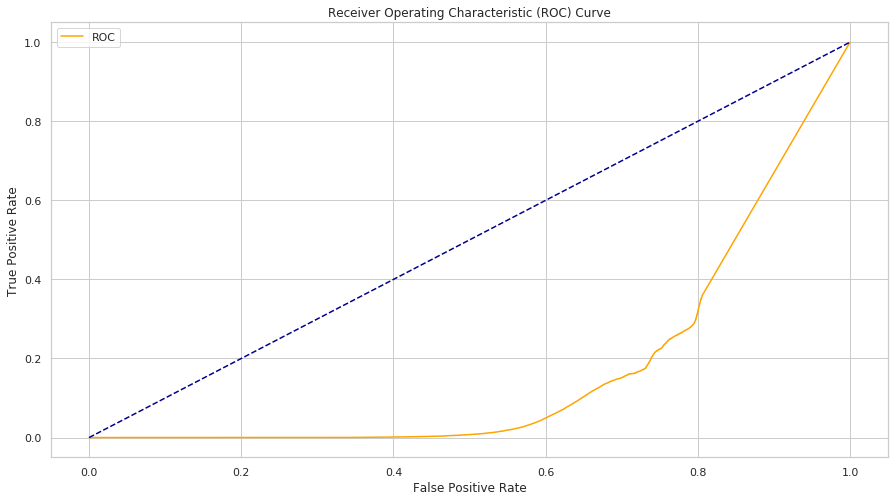





Validation set prediction


Accuracy: 66.07%

Classification Report
               precision    recall  f1-score   support

           0       0.76      0.84      0.79    143160
           1       0.02      0.01      0.02     39247

    accuracy                           0.66    182407
   macro avg       0.39      0.43      0.41    182407
weighted avg       0.60      0.66      0.63    182407



Confusion-matrix
 Predicted Species       0      1
Actual Species                  
0                  119956  23204
1                   38687    560


ROC-AUC: 0.4831151919125939



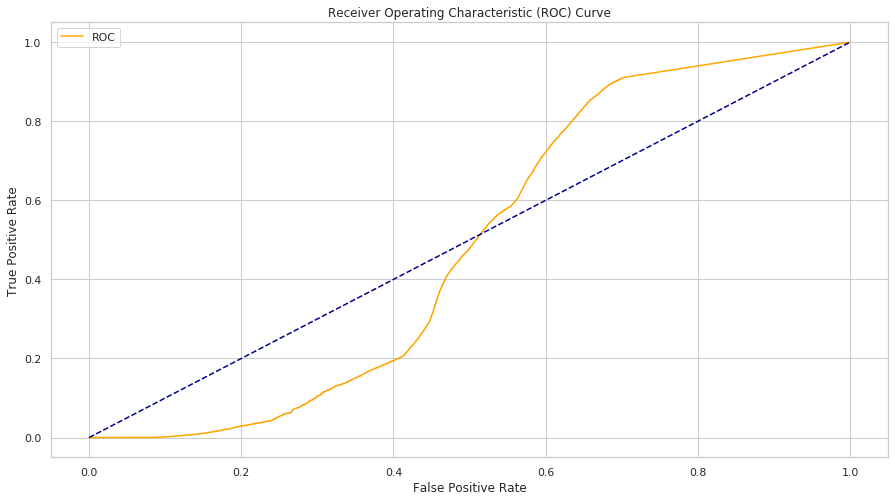

In [0]:
SGDClassifier_model = linear_model.SGDClassifier(alpha=0.01, average=False, class_weight=None, early_stopping=True,
              epsilon=0.1, eta0=0.2, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

SGDClassifier_model = linear_model.SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.2, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='modified_huber',
              max_iter=500, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=False, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

selectTopFeatures=True;

if selectTopFeatures:
  feature_map_nystroem = Nystroem(random_state=0,n_components=10)
  X_train_svc = feature_map_nystroem.fit_transform(X_train)
  X_test_svc = feature_map_nystroem.fit_transform(X_test)
  X_valid_svc = feature_map_nystroem.fit_transform(X_valid)

  SGDClassifier = SGDClassifier_model.fit(X_train_svc, y_train)
  predict(SGDClassifier, X_test_svc, y_test,"Test set prediction")
  predict(SGDClassifier, X_valid_svc, y_valid,"Validation set prediction")
else:
  SGDClassifier = SGDClassifier_model.fit(X_train, y_train)
  predict(SGDClassifier, X_test, y_test,"Test set prediction")
  predict(SGDClassifier, X_valid, y_valid,"Validation set prediction")

In [0]:
# ---> Decision Tree <---

In [0]:
decisionTree_model = DecisionTreeClassifier(max_features='auto')
decisionTree = decisionTree_model.fit(X_train, y_train)
joblib.dump(decisionTree, 'decisionTree.sav')

predict(decisionTree, X_test, y_test,"Test set prediction")
predict(decisionTree, X_valid, y_valid,"Validation set prediction")

In [0]:
# ---> Random Forest <---

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [5, 10, 15, 20]
min_samples_leaf = [2, 4, 6, 8, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 10, n_jobs=-1, verbose = 2)
randomForest_randomSearch = random_search.fit(X_train, y_train)

pprint(randomForest_randomSearch.best_params_)
predict(randomForest_randomSearch, X_test, y_test,"Test set prediction")
predict(randomForest_randomSearch, X_valid, y_valid,"Validation set prediction")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  81 | elapsed:   54.3s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.4min finished


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 11,
 'n_estimators': 70}


Test set prediction


Accuracy: 99.49%

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     70112
           1       0.99      0.99      0.99     17897

    accuracy                           0.99     88009
   macro avg       0.99      0.99      0.99     88009
weighted avg       0.99      0.99      0.99     88009



Confusion-matrix
 Predicted Species      0      1
Actual Species                 
0                  69876    236
1                    217  17680


ROC-AUC: 0.999863821920719



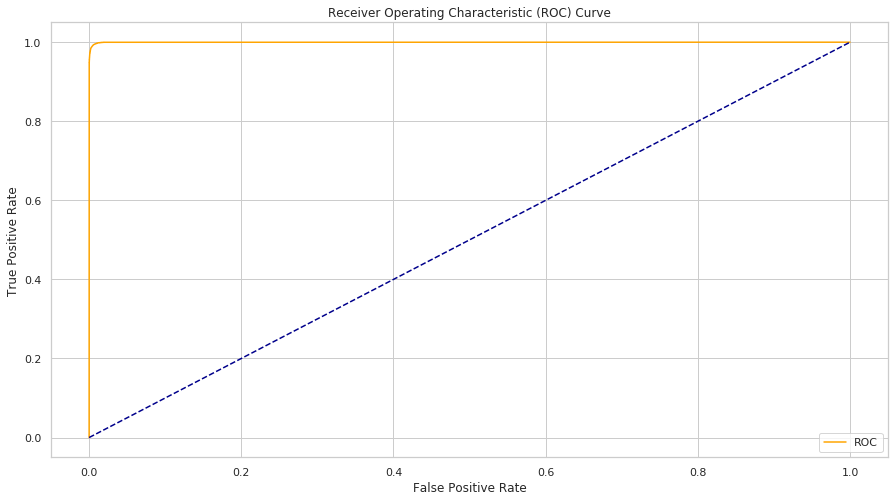





Validation set prediction


Accuracy: 99.49%

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56197
           1       0.99      0.99      0.99     14210

    accuracy                           0.99     70407
   macro avg       0.99      0.99      0.99     70407
weighted avg       0.99      0.99      0.99     70407



Confusion-matrix
 Predicted Species      0      1
Actual Species                 
0                  55995    202
1                    155  14055


ROC-AUC: 0.9998562905848816



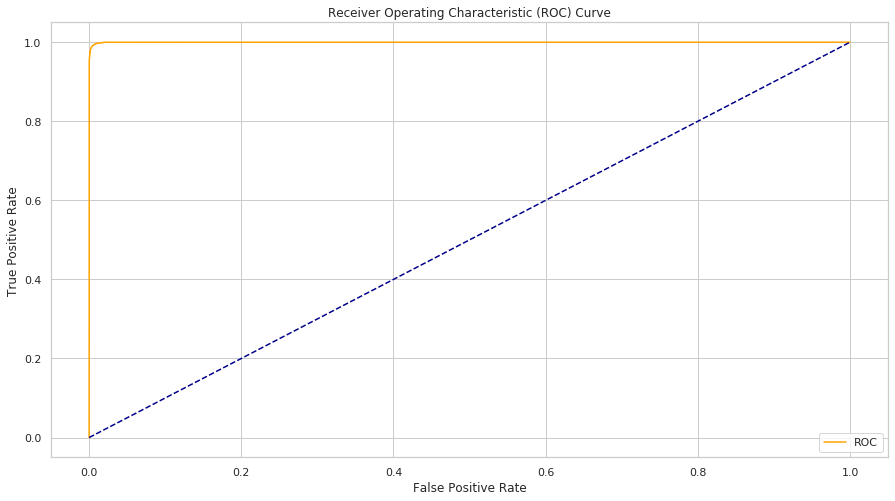

In [0]:
params = {'n_estimators': [130,150],
          'max_features': ['log2'],
          'max_depth': [130,150],
          'min_samples_split': [8,10],
          'min_samples_leaf': [5],
          'bootstrap': [False]}

params = {'bootstrap': [False],
          'max_depth': [None],
          'max_features': ['auto'],
          'min_samples_leaf': [5,6,7],
          'min_samples_split': [11,13,15],
          'n_estimators': [50,70,90]}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 3, n_jobs=-1, verbose = 2)
randomForest_gridSearch = grid_search.fit(X_train, y_train)

pprint(randomForest_gridSearch.best_params_)
predict(randomForest_gridSearch, X_test, y_test,"Test set prediction")
predict(randomForest_gridSearch, X_valid, y_valid,"Validation set prediction")

Selected features: Index(['srcip', 'dstip', 'sbytes', 'sttl', 'dttl', 'Dload', 'smeansz',
       'dmeansz', 'ct_state_ttl'],
      dtype='object')


Test set prediction


Accuracy: 98.96%

Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    178480
           1       0.98      0.97      0.98     49529

    accuracy                           0.99    228009
   macro avg       0.99      0.98      0.98    228009
weighted avg       0.99      0.99      0.99    228009



Confusion-matrix
 Predicted Species       0      1
Actual Species                  
0                  177394   1086
1                    1283  48246


ROC-AUC: 0.9995694972187085



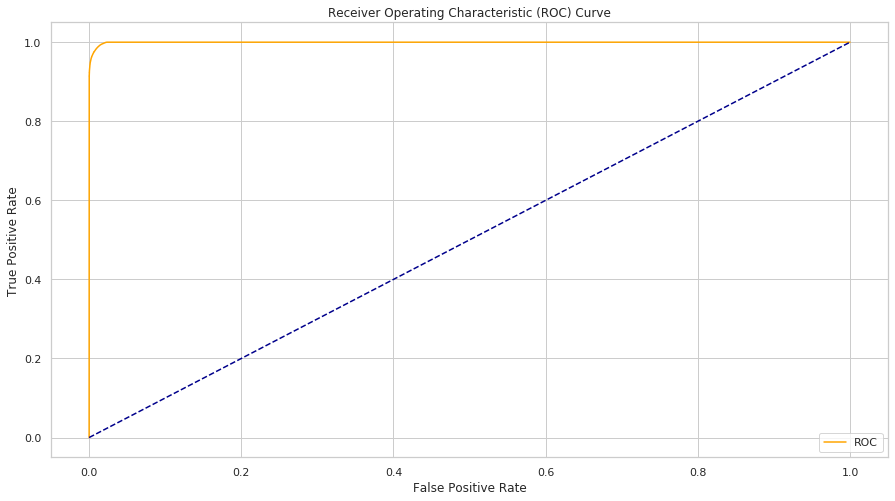





Validation set prediction


Accuracy: 98.96%

Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    143160
           1       0.98      0.97      0.98     39247

    accuracy                           0.99    182407
   macro avg       0.99      0.98      0.98    182407
weighted avg       0.99      0.99      0.99    182407



Confusion-matrix
 Predicted Species       0      1
Actual Species                  
0                  142290    870
1                    1028  38219


ROC-AUC: 0.9995624493161155



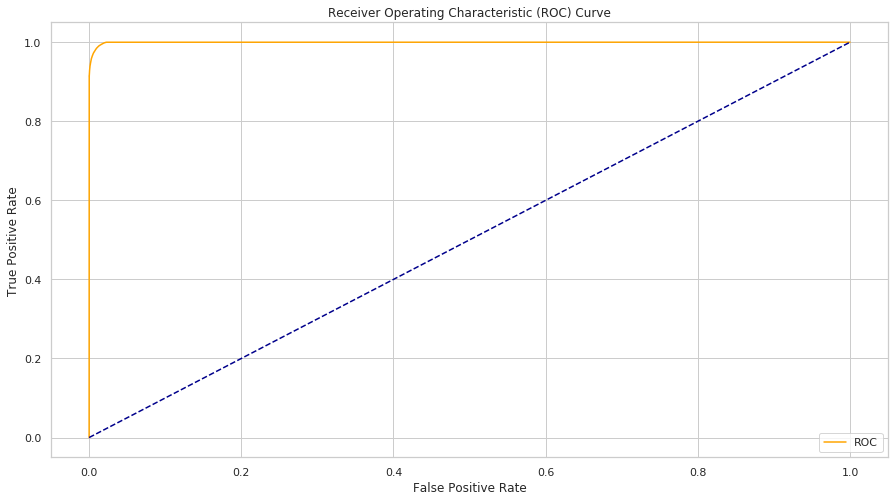

In [0]:
#randomForestModel = RandomForestClassifier(n_estimators=110,max_features='log2',max_depth=120,min_samples_split=8,min_samples_leaf=5,bootstrap=False,n_jobs=-1)
randomForestModel = RandomForestClassifier(n_estimators=70,max_features='auto',max_depth=None,min_samples_split=11,min_samples_leaf=5,bootstrap=False,n_jobs=-1)

selectTopFeatures=True;

if selectTopFeatures:
  selected_features = SelectFromModel(randomForestModel)
  selected_features.fit(X_train, y_train)
  features = X_train.columns[(selected_features.get_support())]
  X_train_randForest = selected_features.transform(X_train)
  X_test_randForest = selected_features.transform(X_test)
  X_valid_randForest = selected_features.transform(X_valid)

  print("Selected features: {}".format(features))

  randomForest = randomForestModel.fit(X_train_randForest, y_train)
  joblib.dump(randomForest, 'randomForest_selectedFeatures.sav')
  predict(randomForest, X_test_randForest, y_test,"Test set prediction")
  predict(randomForest, X_valid_randForest, y_valid,"Validation set prediction")
else:
  randomForest = randomForestModel.fit(X_train, y_train)
  joblib.dump(randomForest, 'randomForest.sav')
  predict(randomForest, X_test, y_test,"Test set prediction")
  predict(randomForest, X_valid, y_valid,"Validation set prediction")